# One-shot Learning Sziami halozattal

Az alabbi programot a testverparkepeken vegzett vizsgalataimhoz keszitettem, melynek reszletes magyarazataul a Szakdolgozatom szolgal. A program csak a szukseges hattertarra mentett pickle objektumokkal nyer ertelmet, melynek elkeszitesehez a SiblingsDB_Loader.ipynb fajl hasznalhato.

In [1]:
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy.random as rng
import numpy as np
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

Using TensorFlow backend.


###### A kovetkezok fuggvenyek segitenek a fajlok es eredmenyek kezeleseben. valamint a halozat inicializalasat konnyitik meg

In [2]:
def W_init(shape, name=None):
    values = rng.normal(loc=0, scale=1e-2,size=shape)
    return K.variable(values, name=name)

def b_init(shape, name=None):
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_best_acc(best_acc_str):
    with open('accuraciesSIB.txt') as f:
        content = f.readlines()
    best_acc = 0
    for line in content:
        if line.find(best_acc_str) >= 0:
            cont = line.split(' ')
            best_acc = int(cont[1])
    return best_acc

def save_best_acc(best_acc_str, best_acc):
    with open('accuraciesSIB.txt', 'r') as f :
        content = f.readlines()
    exists = False
    for i, s in enumerate(content):
        if content[i].find(best_acc_str) >= 0:
            content[i] = best_acc_str + ': ' + str(best_acc)
            exists = True
    if not exists:
        content.append(best_acc_str + ': ' + str(best_acc) + '\n')
    with open('accuraciesSIB.txt', 'w') as f:
        f.writelines(content)
    print(content)

#### Sziami halozat osszeallitasa

In [6]:
input_shape=(105, 105,1)
left_input = Input(input_shape)
right_input = Input(input_shape)

model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(Flatten())
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

absolute_distance = lambda x: K.abs(x[0]-x[1])
both = merge([model(left_input),model(right_input)], mode = absolute_distance, output_shape = lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

optimizer = Adam(0.00006)
siamese_net.compile(loss='binary_crossentropy',optimizer=optimizer)
siamese_net.count_params()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


38951745

#### Manager osztaly implementalasa

In [48]:
class SiameseManager:
    '''
    Propertyk:
    - n_classes: ennyi osztaly van a tanulo adathalmazban
    - n_samples: ennyi minta van egy osztalyhoz
    - w: a kepek szelessege (105)
    - h: a kepek magassaga (105)
    - data: a beolvasott adatok szeparalva tanito es tesztelo reszekre
    '''
    def __init__(self, path):
        self.data = {}
        with open(os.path.join(path,"train_sib_full.pickle"), "rb") as f:
            (X, c) = pickle.load(f)
            self.data["train"] = X
        with open(os.path.join(path,"val_sib_full.pickle"), "rb") as f:
            (X, c) = pickle.load(f)
            self.data["test"] = X
        self.n_classes,self.n_samples,self.w,self.h = self.data['train'].shape
    
    '''
    A fuggveny a tanulo halmazbol batch_size mintapart valaszt ki es oszlopvektorokat alakit ki beloluk
    A parok egyik fele megegyezo osztalybol, a masodik kulonbozo osztalybol szarmazik
    '''
    def get_batch(self, batch_size):
        X = self.data['train']
        classes = rng.choice(self.n_classes, size=(batch_size,), replace=False)
        pairs=[np.zeros((batch_size, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            class_ = classes[i]
            idx_1 = rng.randint(0,self.n_samples)
            pairs[0][i,:,:,:] = X[class_,idx_1].reshape(self.w, self.h, 1)
#             idx_2 = rng.randint(0,self.n_samples) # Omniglot eseteben ez kellene
            idx_2 = 0 if idx_1==1 else 1 # SiblingsDB eseten
            class_2 = class_ if i >= batch_size//2 else (class_ + rng.randint(1, self.n_classes)) % self.n_classes 
            pairs[1][i,:,:,:] = X[class_2, idx_2].reshape(self.w, self.h, 1)
        return pairs, targets
    
    '''
    A fuggveny n_imgpairs darab tesztparral ter vissza a dolgozatban ismertett rendszerben
    '''
    def get_test_imgpairs(self, n_imgpairs):
        X = self.data['test']
        n_classes,n_samples = X.shape[0],X.shape[1]
        classes = rng.choice(range(n_classes), size=(n_imgpairs,), replace=False)
        indicies = rng.randint(0, self.n_samples, size=(n_imgpairs,))
        true_class = classes[0]
        ex1,ex2 = rng.choice(n_samples, size=(2,), replace=False)
        test_image = np.asarray([X[true_class, ex1,:,:]] * n_imgpairs).reshape(n_imgpairs, self.w, self.h, 1)
        support_set = X[classes, indicies,:,:]
        support_set[0,:,:] = X[true_class, ex2]
        support_set = support_set.reshape(n_imgpairs, self.w, self.h, 1)
        targets = np.zeros((n_imgpairs,))
        targets[0] = 1
        targets,test_image,support_set=shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, targets
    
    '''
    A test_oneshot n_test szamu tesztet hajt vegre a sziami halozaton, majd a szazalekos eredmenyt visszajelzi
    '''
    def test_oneshot(self, model, n_imgpairs, n_test):
        n_correct = 0
        print("Doing " + str(n_test) + " with " + str(n_imgpairs) + " image pairs ")
        for i in range(0, n_test):
            inputs, targets = self.get_test_imgpairs(n_imgpairs)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        test_result = (100 * n_correct / n_test)
        print("The TEST result is: " + str(test_result) + "%")
        return test_result

###### Futtatasi parameterek beallitasa, SiameseManager osztaly peldanyositasa, kornyezet lementese es informaciok beolvasasa

In [50]:
batch_size = 32
n_imgpairs = 2
n_test = 1
max_iter = 1
evaluate_every = 1

manager = SiameseManager("")
best_acc_str = 'sib_full_best' + str(batch_size) + '_' + str(n_imgpairs) + '_' + str(n_test) + '_' + str(max_iter)
best_acc = load_best_acc(best_acc_str)
print("The best accuracy so far with this setup: " + str(best_acc))
result_number = load_obj('result_number') + 1
results_detail = load_obj('sib_results_detail')
results_detail[str(str(result_number) + '_' + best_acc_str)] = {'%': [], 'iteration': [], 'loss': []}

The best accuracy so far with this setup: 0


###### Ezzel az osszeallitassal eddig best_acc volt a legjobb eredmeny, a kornyezet leirasat a best_acc_str tarolja, a reszletes eredmenyeket a results_detail, az eredmenyek szamat, pedig a result_number tartalmazza

In [51]:
print(best_acc_str)
print(results_detail)
print(result_number)

sib_full_best32_2_1_1
{'7_sib_best32_25_50_1000': {'%': [0, 0, 10, 4, 2, 2, 4, 2, 2, 6, 10, 8, 6, 8, 6, 4, 6, 8, 12, 8, 2, 12, 10, 2, 16, 4, 2, 10, 8, 12, 8, 6, 8, 8, 4, 2, 10, 18, 8, 4, 2], 'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000], 'loss': [8.3149223, 6.9010038, 5.8805571, 5.0919342, 4.4589329, 3.9434114, 3.444129, 3.0301409, 2.6868663, 2.3709469, 2.1039548, 1.8704481, 1.7224824, 1.4966536, 1.3251293, 1.2097166, 1.0616653, 0.97349751, 0.86911505, 0.76569593, 0.71485537, 0.6352551, 0.57001913, 0.52549338, 0.46832636, 0.42366433, 0.38276154, 0.34967735, 0.31482255, 0.28569663, 0.25928563, 0.23591852, 0.21533932, 0.20347062, 0.17987517, 0.21757844, 0.19528787, 0.16879763, 0.18370979, 0.14750916, 0.14532425]}, '8_sib_eye_best32_10_50_500': {'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,

### A halozat tanitasa es tesztelese

A szakdolgozatomban ismertett modon tanitjuk es teszteljuk a halozatot

In [54]:
# siamese_net.load_weights(best_acc_str)

for i in range(0, max_iter + 1):
    (inputs, targets) = manager.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        test_acc = manager.test_oneshot(siamese_net, n_imgpairs, n_test)
        results_detail[str(result_number) + '_' + best_acc_str]['%'].append(test_acc)
        results_detail[str(result_number) + '_' + best_acc_str]['iteration'].append(i)
        results_detail[str(result_number) + '_' + best_acc_str]['loss'].append(loss)
        if test_acc >= best_acc:
            siamese_net.save(best_acc_str) 
            print("The best parameters are saved")
            best_acc = test_acc
        print("Iteration number: " + str(i) + " Training loss: " + str(loss))      
print("The BEST accuracy is: " + str(best_acc))

Doing 1 with 2 image pairs 
The TEST result is: 100%
The best parameters are saved
Iteration number: 0 Training loss: 7.746
Doing 1 with 2 image pairs 
The TEST result is: 0%
Iteration number: 1 Training loss: 7.77252
The BEST accuracy is: 100


### A kovetkezo kodot CSAK akkor erdemes futtatni, ha elszeretnenk menteni a futast

In [175]:
save_obj(results_detail, 'sib_results_detail')
save_obj(result_number, 'result_number')
save_best_acc(best_acc_str, best_acc)

['BEST_ACC64_25_50: 72\n', 'BEST_ACC32_25_550: 54\n', 'BEST_ACC32_25_50: 44\n', 'BEST_ACC64_50_250: 47\n', 'sib_best32_10_50_101: 28\n', 'sib_best32_25_100_200: 16\n', 'sib_best32_25_50_1000: 18\n', 'sib_eye_best32_10_50_500: 30\n', 'sib_nose_best32_10_50_500: 26\n', 'sib_mouth_best32_10_50_500: 28\n', 'sib_full_best32_10_50_500: 38\n']


#### A lentebbi fuggvenyek az eredmenyek kiertekelesehez kellettek

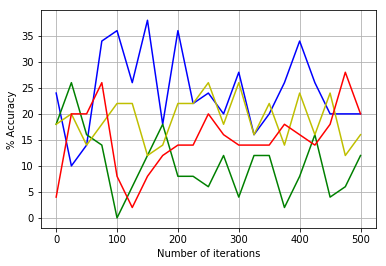

In [284]:
import matplotlib.pyplot as plt

plt.plot(results_detail['13_sib_full_best32_10_50_500']['iteration'], results_detail['13_sib_full_best32_10_50_500']['%'],'b-',
         results_detail['8_sib_eye_best32_10_50_500']['iteration'], results_detail['8_sib_eye_best32_10_50_500']['%'],'g-',
        results_detail['9_sib_nose_best32_10_50_500']['iteration'], results_detail['9_sib_nose_best32_10_50_500']['%'],'y-',
        results_detail['10_sib_mouth_best32_10_50_500']['iteration'], results_detail['10_sib_mouth_best32_10_50_500']['%'],'r-')
plt.ylabel('% Accuracy')
plt.xlabel('Number of iterations')
plt.grid(True)
# plt.text(150, 9, 'n_imgpairs=25\nn_test=100', color='green', fontsize='12')
# plt.text(110, 21, 'n_imgpairs=10\nn_test=50', color='blue', fontsize='12')
plt.show()

In [273]:
def create_table(base_path):
    columns = ['Family1', 'Family2','Person1', 'Person2', 'full', 'eye', 'nose', 'mouth']
    indices = [int(family) for family in os.listdir(base_path)]
    df = pd.DataFrame(columns=columns)

    iteration = 0
    for family in os.listdir(base_path):
        for i in range(0,2):
            Family1 = int(family)
            if iteration % 2 == 1:
                Family2 = int(family)
            else:
                Family2 = int(family)
                while Family2 == int(family):
                    Family2 = int(indices[rng.randint(0,84)])

            family_path = os.path.join(base_path, family)
            person_num = 0
            for person in os.listdir(family_path):
                if '.jpg' in person and person_num == 0:
                    Person1 = person
                    person_num += 1
                elif '.jpg' in person and person_num == 1:
                    Person2 = person
                    person_num += 1

            if iteration % 2 == 0:
                for person in os.listdir(os.path.join(base_path, str(Family2))):
                    if '.jpg' in person:
                        Person2 = person
                        break
            iteration += 1
            df.loc[-1] = [Family1, Family2, Person1, Person2, '', '', '', '']
            df.index = df.index + 1  # shifting index
            df = df.sort_index()

    df['index'] = df.index
    df = df.sort_values(['Family1', 'index'])
    del df['index']
    df = df.reset_index(drop=True)
    return df

In [285]:
import pandas as pd
from PIL import Image
import os
import sys

SIGNAL = 'mouth'
NETWORK = 'sib_mouth_best32_10_50_500'
base_path = 'SiblingsDB/DBs/HQf_withPairs'

# df = create_table(base_path)
siamese_net.load_weights(NETWORK)
df = pd.read_csv('prediction_table.csv', index_col=0)

for index, row in df.iterrows():
    input1_path = os.path.join(base_path, str(row['Family1']), row['Person1'].split('.jpg')[0] + SIGNAL + '.jpeg')
    input2_path = os.path.join(base_path, str(row['Family2']), row['Person2'].split('.jpg')[0] + SIGNAL + '.jpeg')
    input1 = np.array(Image.open(input1_path)).reshape(1,105,105,1)
    input2 = np.array(Image.open(input2_path)).reshape(1,105,105,1)
    df.set_value(index, SIGNAL, round(siamese_net.predict([input1, input2]), 3))
                
df.to_csv('prediction_table.csv', sep=';')
print(df)



     Family1  Family2       Person1         Person2   full    eye   nose  \
0          1        1  _DSC5751.jpg  _DSC5755_1.jpg  0.971  0.995  0.988   
1          1      218  _DSC5751.jpg    _DSC2232.jpg  0.000  0.016  0.000   
2          5        5  _DSC5763.jpg    _DSC5760.jpg  0.861  0.992  0.989   
3          5      194  _DSC5763.jpg         195.jpg  0.009  0.000  0.000   
4          7        7  _DSC5769.jpg    _DSC5774.jpg  0.933  0.998  0.993   
5          7      185  _DSC5769.jpg    _DSC0751.jpg  0.009  0.001  0.000   
6          9        9  _DSC5804.jpg    _DSC5792.jpg  0.961  0.997  0.990   
7          9       62  _DSC5804.jpg    _DSC9913.jpg  0.000  0.000  0.000   
8         13       13  _DSC5818.jpg    _DSC5826.jpg  0.903  0.993  0.994   
9         13        7  _DSC5818.jpg    _DSC5769.jpg  0.073  0.007  0.008   
10        15       15  _DSC5850.jpg    _DSC5843.jpg  0.946  0.994  0.987   
11        15      150  _DSC5850.jpg    _DSC0572.jpg  0.001  0.000  0.000   
12        17